<a href="https://colab.research.google.com/github/Patience3/Translator_French_to-_English/blob/main/Text_To_Text_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# seq2seq_train_eval.py
from __future__ import unicode_literals, print_function, division
import unicodedata, re, random, time, math, sys, os
from collections import Counter
import copy

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from torch import optim


In [ ]:

# ========== Environment & Seeds ==========
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("[ENV] Device selected:", DEVICE)

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# ========== Tokens & Hyperparameters ==========
PAD_token = 0
SOS_token = 1
EOS_token = 2

DATAFILE = 'eng-fra.txt'   # expects tab-separated "eng \t fra" lines
MAX_LENGTH = 9
HIDDEN_SIZE = 256
N_EPOCHS = 12
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
VAL_FRAC = 0.1
TEST_FRAC = 0.1
MAX_PAIRS_FOR_TRAINING = 20000
PATIENCE = 4

In [ ]:
# ========== Utilities & Preprocessing ==========
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s.strip()

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        # Reserve PAD=0, SOS=1, EOS=2
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.n_words = 3

    def addSentence(self, sentence):
        for w in sentence.split():
            self.addWord(w)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

def readLangs(filename=DATAFILE, reverse=False):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    pairs = []
    for l in lines:
        if '\t' not in l:
            continue
        a, b = l.split('\t')
        pairs.append([normalizeString(a), normalizeString(b)])
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang('fra' if reverse else 'eng')
        output_lang = Lang('eng' if reverse else 'fra')
    else:
        input_lang = Lang('eng')
        output_lang = Lang('fra')
    return input_lang, output_lang, pairs

def filterPair(p):
    return len(p[0].split()) < MAX_LENGTH and len(p[1].split()) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def indexesFromSentence(lang, sentence):
    # ignore unknown tokens (they won't be in vocab)
    return [lang.word2index[w] for w in sentence.split() if w in lang.word2index]

def prepareData(filename=DATAFILE, reverse=False):
    input_lang, output_lang, pairs = readLangs(filename, reverse)
    # 1. Filter
    pairs = filterPairs(pairs)
    print(f"[DATA] Filtered pairs: kept {len(pairs)} pairs (MAX_LENGTH={MAX_LENGTH})")
    # 2. Limit
    if len(pairs) > MAX_PAIRS_FOR_TRAINING:
        random.shuffle(pairs)
        pairs = pairs[:MAX_PAIRS_FOR_TRAINING]
    print(f"[DATA] Using {len(pairs)} pairs after limiting to {MAX_PAIRS_FOR_TRAINING}")
    # 3. Build Vocab
    for p in pairs:
        input_lang.addSentence(p[0])
        output_lang.addSentence(p[1])
    print(f"[VOCAB] Input ({input_lang.name}) vocab size: {input_lang.n_words}")
    print(f"[VOCAB] Output ({output_lang.name}) vocab size: {output_lang.n_words}")
    return input_lang, output_lang, pairs

# ========== Dataset building & deterministic split ==========
def build_tensor_from_pairs(input_lang, output_lang, pairs_list):
    n = len(pairs_list)
    input_ids = np.full((n, MAX_LENGTH), PAD_token, dtype=np.int32)
    target_ids = np.full((n, MAX_LENGTH), PAD_token, dtype=np.int32)
    for idx, (inp, tgt) in enumerate(pairs_list):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids = inp_ids[:MAX_LENGTH - 1] + [EOS_token]
        tgt_ids = tgt_ids[:MAX_LENGTH - 1] + [EOS_token]
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids
    return TensorDataset(torch.LongTensor(input_ids).to(DEVICE),
                         torch.LongTensor(target_ids).to(DEVICE))

def get_dataloader(input_lang, output_lang, pairs, batch_size, seed=42):
    pairs_shuffled = pairs.copy()
    rng = random.Random(seed)
    rng.shuffle(pairs_shuffled)

    n_total = len(pairs_shuffled)
    n_test = int(n_total * TEST_FRAC)
    n_val = int(n_total * VAL_FRAC)
    n_train = n_total - n_val - n_test

    train_pairs = pairs_shuffled[:n_train]
    val_pairs = pairs_shuffled[n_train:n_train + n_val]
    test_pairs = pairs_shuffled[n_train + n_val:]

    print(f"[DATA] Split sizes → Train: {len(train_pairs)} | Val: {len(val_pairs)} | Test: {len(test_pairs)}")

    train_dataset = build_tensor_from_pairs(input_lang, output_lang, train_pairs)
    val_dataset = build_tensor_from_pairs(input_lang, output_lang, val_pairs)
    test_dataset = build_tensor_from_pairs(input_lang, output_lang, test_pairs)

    train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    return train_dataloader, val_dataloader, test_dataloader, train_pairs, val_pairs, test_pairs


In [ ]:

# ========== Model Definitions ==========
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, cell='gru', dropout_p=0.3):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size, padding_idx=PAD_token)
        self.dropout = nn.Dropout(dropout_p)
        if cell == 'gru':
            self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True, bidirectional=True)
        elif cell == 'rnn':
            self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True, bidirectional=True)
        else:
            raise ValueError("Unsupported cell type.")

    def forward(self, input_tensor):
        embedded = self.dropout(self.embedding(input_tensor))
        output, hidden = self.rnn(embedded)
        # hidden shape (num_directions, B, H) -> we assume single layer -> (2, B, H)
        # combine forward & backward -> (1, B, 2*H)
        hidden = torch.cat((hidden[0:1], hidden[1:2]), dim=2)
        return output, hidden

class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, cell='gru'):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size, padding_idx=PAD_token)
        # map encoder (2*H) -> decoder H
        self.hidden_to_hidden = nn.Linear(hidden_size * 2, hidden_size)
        if cell == 'gru':
            self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)
        elif cell == 'rnn':
            self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        else:
            raise ValueError("Unsupported cell type.")
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        # encoder_hidden: (1, B, 2*H)
        batch_size = encoder_outputs.size(0)
        # Map to decoder initial hidden: (1, B, H)
        initial_hidden = encoder_hidden.squeeze(0)           # (B, 2H)
        initial_hidden = F.relu(self.hidden_to_hidden(initial_hidden))  # (B, H)
        decoder_hidden = initial_hidden.unsqueeze(0)         # (1, B, H)

        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=DEVICE).fill_(SOS_token)
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            emb = self.embedding(decoder_input)              # (B,1,H)
            emb = F.relu(emb)
            output, decoder_hidden = self.rnn(emb, decoder_hidden)  # output: (B,1,H)
            output = self.out(output)                        # (B,1, vocab)
            decoder_outputs.append(output)
            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _, topi = output.topk(1)                    # (B,1,1)
                decoder_input = topi.squeeze(-1).detach()   # (B,1)
        decoder_outputs = torch.cat(decoder_outputs, dim=1)    # (B, L, vocab)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden


In [ ]:

# ========== Training / Eval Utilities ==========
def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    encoder.train(); decoder.train()
    total_loss = 0.0
    for input_tensor, target_tensor in dataloader:
        encoder_optimizer.zero_grad(); decoder_optimizer.zero_grad()
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)
        loss = criterion(decoder_outputs.view(-1, decoder_outputs.size(-1)), target_tensor.view(-1))
        loss.backward()
        encoder_optimizer.step(); decoder_optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def ngrams(tokens, n):
    return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)] if len(tokens)>=n else []

def clipped_precision(reference, hypothesis, n):
    ref_counts = Counter(ngrams(reference, n))
    hyp_counts = Counter(ngrams(hypothesis, n))
    clipped = 0; total = 0
    for gram in hyp_counts:
        total += hyp_counts[gram]
        clipped += min(hyp_counts[gram], ref_counts.get(gram, 0))
    return clipped, total

def sentence_bleu(reference, hypothesis, max_n=4):
    weights = [1.0/max_n]*max_n
    precisions = []
    for n in range(1, max_n+1):
        clipped, total = clipped_precision(reference, hypothesis, n)
        p = (clipped / total) if total > 0 else 0.0
        precisions.append(p)
    if not all(p > 0 for p in precisions):
        return 0.0
    s = sum(w * math.log(p) for w, p in zip(weights, precisions))
    geo_mean = math.exp(s)
    ref_len = len(reference); hyp_len = len(hypothesis)
    bp = 1.0 if hyp_len > ref_len else math.exp(1 - ref_len / max(1, hyp_len))
    return bp * geo_mean

@torch.no_grad()
def evaluate_loss_and_bleu(dataloader, encoder, decoder, criterion, output_lang, total_samples):
    encoder.eval(); decoder.eval()
    val_loss_total = 0.0
    bleu_total = 0.0
    sample_count = 0
    for input_tensor, target_tensor in dataloader:
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)
        loss = criterion(decoder_outputs.view(-1, decoder_outputs.size(-1)), target_tensor.view(-1))
        val_loss_total += loss.item()
        # Greedy decode for BLEU
        decoder_outputs_greedy, _ = decoder(encoder_outputs, encoder_hidden, target_tensor=None)
        _, topi = decoder_outputs_greedy.topk(1)  # (B,L,1)
        decoded_ids = topi.squeeze(-1)           # (B,L)
        bs = input_tensor.size(0)
        for i in range(bs):
            ref_ids = [idx.item() for idx in target_tensor[i] if idx.item() not in (PAD_token, SOS_token, EOS_token)]
            ref_tokens = [output_lang.index2word.get(idx, '<UNK>') for idx in ref_ids]
            hyp_ids = []
            for idx in decoded_ids[i]:
                idxi = idx.item()
                if idxi == EOS_token: break
                if idxi != SOS_token and idxi != PAD_token:
                    hyp_ids.append(idxi)
            hyp_tokens = [output_lang.index2word.get(idx, '<UNK>') for idx in hyp_ids]
            bleu_total += sentence_bleu(ref_tokens, hyp_tokens)
            sample_count += 1
    avg_val_loss = val_loss_total / len(dataloader) if len(dataloader) > 0 else 0.0
    avg_bleu = bleu_total / max(1, sample_count)
    return avg_val_loss, avg_bleu

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    if len(indexes) >= MAX_LENGTH:
        indexes = indexes[:MAX_LENGTH - 1]
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=DEVICE).view(1, -1)

@torch.no_grad()
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    encoder.eval(); decoder.eval()
    input_tensor = tensorFromSentence(input_lang, sentence)
    encoder_outputs, encoder_hidden = encoder(input_tensor)
    # Map encoder hidden to decoder initial using decoder.hidden_to_hidden
    initial_hidden = encoder_hidden.squeeze(0)
    initial_hidden = F.relu(decoder.hidden_to_hidden(initial_hidden))
    decoder_hidden = initial_hidden.unsqueeze(0)
    decoder_input = torch.empty(1, 1, dtype=torch.long, device=DEVICE).fill_(SOS_token)
    decoded_words = []
    for _ in range(MAX_LENGTH):
        emb = decoder.embedding(decoder_input)
        emb = F.relu(emb)
        output, decoder_hidden = decoder.rnn(emb, decoder_hidden)
        output = decoder.out(output)
        _, topi = output.topk(1)
        next_token_idx = topi.squeeze().item()
        if next_token_idx == EOS_token:
            decoded_words.append('<EOS>')
            break
        decoded_words.append(output_lang.index2word.get(next_token_idx, '<UNK>'))
        decoder_input = torch.tensor([[next_token_idx]], device=DEVICE)
    return decoded_words


In [ ]:

# ========== Model training loop (with early stopping) ==========
def train_model(model_name, encoder, decoder, train_dataloader, val_dataloader, train_size, val_size, output_lang, n_epochs, patience=PATIENCE, min_delta=0.0):
    print(f"\n[TRAIN] Starting training for `{model_name}`")
    optimizer_enc = optim.Adam(encoder.parameters(), lr=LEARNING_RATE)
    optimizer_dec = optim.Adam(decoder.parameters(), lr=LEARNING_RATE)
    criterion = nn.NLLLoss(ignore_index=PAD_token)

    train_losses = []; val_losses = []; val_bleus = []
    best_val_loss = float('inf'); epochs_no_improve = 0
    best_enc_state = copy.deepcopy(encoder.state_dict())
    best_dec_state = copy.deepcopy(decoder.state_dict())
    best_epoch = 0
    start_time = time.time()

    for epoch in range(1, n_epochs + 1):
        epoch_start = time.time()
        train_loss = train_epoch(train_dataloader, encoder, decoder, optimizer_enc, optimizer_dec, criterion)
        val_loss, val_bleu = evaluate_loss_and_bleu(val_dataloader, encoder, decoder, criterion, output_lang, val_size)

        train_losses.append(train_loss); val_losses.append(val_loss); val_bleus.append(val_bleu)

        improved = val_loss + min_delta < best_val_loss
        if improved:
            best_val_loss = val_loss
            best_epoch = epoch
            epochs_no_improve = 0
            best_enc_state = copy.deepcopy(encoder.state_dict())
            best_dec_state = copy.deepcopy(decoder.state_dict())
            print(f"  [EARLY STOP] New best model saved (Epoch {epoch}) | Val Loss: {val_loss:.4f}")
        else:
            epochs_no_improve += 1

        epoch_time = time.time() - epoch_start
        print(f"[EPOCH][{model_name}] {epoch}/{n_epochs}  train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_bleu={val_bleu:.4f} | t={int(epoch_time)}s")

        if epochs_no_improve >= patience:
            print(f"[EARLY STOP] No improvement for {patience} epochs; stopping at epoch {epoch}.")
            break

    # load best and save
    encoder.load_state_dict(best_enc_state)
    decoder.load_state_dict(best_dec_state)
    model_path = f"{model_name}.pth"
    torch.save({'encoder': encoder.state_dict(), 'decoder': decoder.state_dict()}, model_path)
    print(f"[MODEL] Saved best model to {model_path} (best epoch {best_epoch})")

    metrics = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_bleu': val_bleus,
        'best_epoch': best_epoch,
        'model_path': model_path
    }
    return encoder, decoder, metrics

In [ ]:


# ========== Plotting helper ==========
def plot_compare(rnn_metrics, gru_metrics):
    rnn_epochs = list(range(1, len(rnn_metrics['train_losses']) + 1))
    gru_epochs = list(range(1, len(gru_metrics['train_losses']) + 1))
    best_rnn_epoch = rnn_metrics.get('best_epoch', len(rnn_epochs))
    best_gru_epoch = gru_metrics.get('best_epoch', len(gru_epochs))

    plt.figure(figsize=(12,6))
    plt.plot(rnn_epochs, rnn_metrics['val_losses'], label='RNN Val Loss', linestyle='--')
    plt.plot(rnn_epochs, rnn_metrics['train_losses'], label='RNN Train Loss')
    plt.plot(gru_epochs, gru_metrics['val_losses'], label='GRU Val Loss', linestyle='--')
    plt.plot(gru_epochs, gru_metrics['train_losses'], label='GRU Train Loss')
    plt.axvline(x=best_rnn_epoch, color='blue', linestyle=':', label=f'RNN Best (E{best_rnn_epoch})')
    plt.axvline(x=best_gru_epoch, color='red', linestyle=':', label=f'GRU Best (E{best_gru_epoch})')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Train/Val Loss Comparison'); plt.legend(); plt.show(); plt.close()

    plt.figure(figsize=(10,5))
    plt.plot(rnn_epochs, rnn_metrics['val_bleu'], label='RNN Val BLEU', marker='o')
    plt.plot(gru_epochs, gru_metrics['val_bleu'], label='GRU Val BLEU', marker='x')
    plt.axvline(x=best_rnn_epoch, color='blue', linestyle=':', label=f'RNN Best (E{best_rnn_epoch})')
    plt.axvline(x=best_gru_epoch, color='red', linestyle=':', label=f'GRU Best (E{best_gru_epoch})')
    plt.xlabel('Epoch'); plt.ylabel('BLEU'); plt.title('Validation BLEU Comparison'); plt.legend(); plt.show(); plt.close()


[ENV] Device selected: cuda

[MAIN] Preparing data...
[DATA] Filtered pairs: kept 78242 pairs (MAX_LENGTH=9)
[DATA] Using 20000 pairs after limiting to 20000
[VOCAB] Input (eng) vocab size: 5596
[VOCAB] Output (fra) vocab size: 8419
[DATA] Split sizes → Train: 16000 | Val: 2000 | Test: 2000

[MAIN] Training Vanilla RNN model...

[TRAIN] Starting training for `RNN_model`
  [EARLY STOP] New best model saved (Epoch 1) | Val Loss: 3.8394
[EPOCH][RNN_model] 1/12  train_loss=4.4631 | val_loss=3.8394 | val_bleu=0.0019 | t=8s
  [EARLY STOP] New best model saved (Epoch 2) | Val Loss: 3.4661
[EPOCH][RNN_model] 2/12  train_loss=3.4665 | val_loss=3.4661 | val_bleu=0.0064 | t=6s
  [EARLY STOP] New best model saved (Epoch 3) | Val Loss: 3.2670
[EPOCH][RNN_model] 3/12  train_loss=3.0682 | val_loss=3.2670 | val_bleu=0.0092 | t=7s
  [EARLY STOP] New best model saved (Epoch 4) | Val Loss: 3.1657
[EPOCH][RNN_model] 4/12  train_loss=2.7883 | val_loss=3.1657 | val_bleu=0.0139 | t=7s
  [EARLY STOP] New best

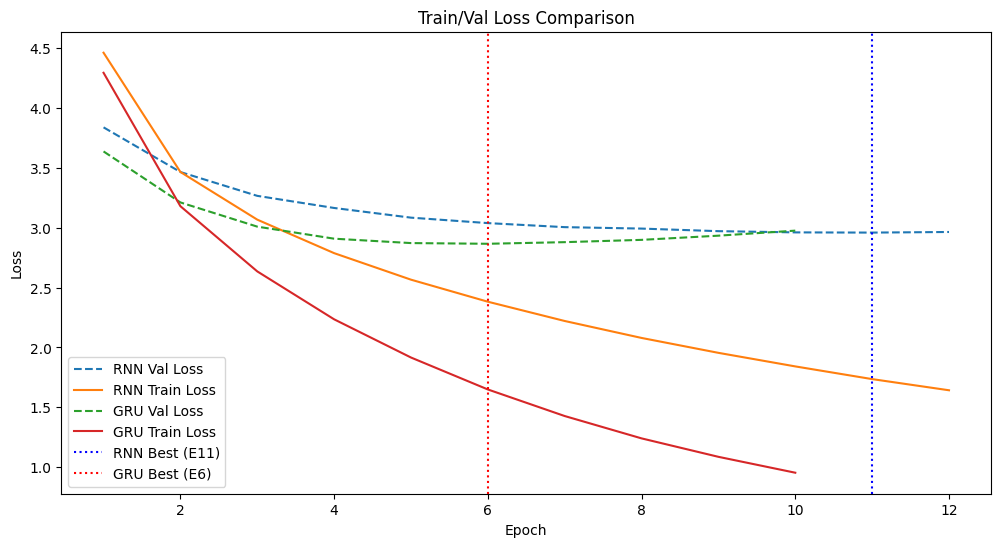

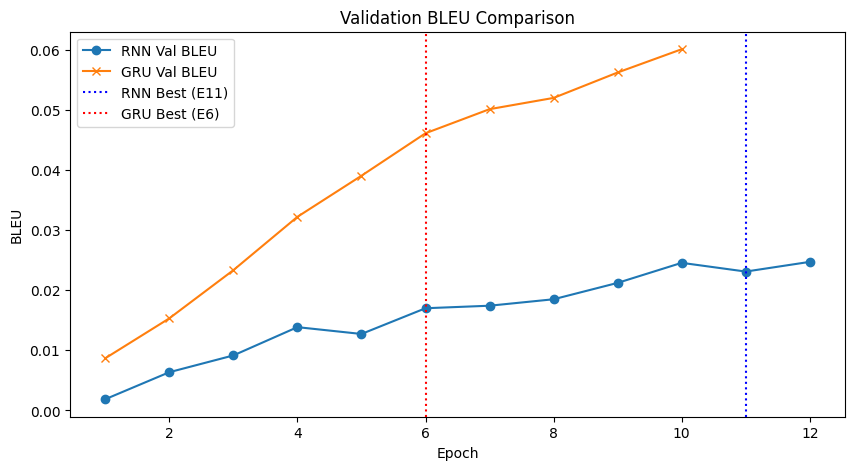


[TEST] Evaluating on held-out test set...

[RNN] Test Loss: 2.9730 | Test BLEU: 0.0201
[GRU] Test Loss: 2.8690 | Test BLEU: 0.0381

Sample translations from held-out test set (input | target | RNN | GRU):
------------------------------------------------------------
Input : move away from me .
Target: eloignez vous de moi .
RNN   : merci pour me recevoir a l aise . <EOS>
GRU   : restez de me me harceler . <EOS>
------------------------------------------------------------
Input : i ve never seen you like this .
Target: je ne vous ai jamais vue ainsi .
RNN   : je ne vous pas vraiment pas mon frere .
GRU   : je ne pourrais vraiment que tu veux . <EOS>
------------------------------------------------------------
Input : is that your car in the driveway ?
Target: est ce ta voiture dans l allee ?
RNN   : est ce que tom etait casse ? <EOS>
GRU   : est ce que ta maison de la maison ?
------------------------------------------------------------
Input : i have bad news for you .
Target: j ai de 

In [1]:

# ========== Main ==========
def main():
    print("\n[MAIN] Preparing data...")
    input_lang, output_lang, pairs = prepareData(DATAFILE, reverse=False)

    train_dataloader, val_dataloader, test_dataloader, train_pairs, val_pairs, test_pairs = get_dataloader(
        input_lang, output_lang, pairs, BATCH_SIZE)

    # Train RNN
    encoder_rnn = Encoder(input_lang.n_words, HIDDEN_SIZE, cell='rnn').to(DEVICE)
    decoder_rnn = Decoder(HIDDEN_SIZE, output_lang.n_words, cell='rnn').to(DEVICE)
    print("\n[MAIN] Training Vanilla RNN model...")
    encoder_rnn, decoder_rnn, rnn_metrics = train_model('RNN_model', encoder_rnn, decoder_rnn,
                                                        train_dataloader, val_dataloader,
                                                        len(train_pairs), len(val_pairs), output_lang, N_EPOCHS)

    # Train GRU
    encoder_gru = Encoder(input_lang.n_words, HIDDEN_SIZE, cell='gru').to(DEVICE)
    decoder_gru = Decoder(HIDDEN_SIZE, output_lang.n_words, cell='gru').to(DEVICE)
    print("\n[MAIN] Training GRU model...")
    encoder_gru, decoder_gru, gru_metrics = train_model('GRU_model', encoder_gru, decoder_gru,
                                                        train_dataloader, val_dataloader,
                                                        len(train_pairs), len(val_pairs), output_lang, N_EPOCHS)

    # Plot comparison
    try:
        plot_compare(rnn_metrics, gru_metrics)
    except Exception as e:
        print("[PLOT] Plotting failed:", e)

    # Final test evaluation on held-out test set
    criterion = nn.NLLLoss(ignore_index=PAD_token)
    print("\n[TEST] Evaluating on held-out test set...")
    test_loss_rnn, test_bleu_rnn = evaluate_loss_and_bleu(test_dataloader, encoder_rnn, decoder_rnn, criterion, output_lang, len(test_pairs))
    test_loss_gru, test_bleu_gru = evaluate_loss_and_bleu(test_dataloader, encoder_gru, decoder_gru, criterion, output_lang, len(test_pairs))

    print(f"\n[RNN] Test Loss: {test_loss_rnn:.4f} | Test BLEU: {test_bleu_rnn:.4f}")
    print(f"[GRU] Test Loss: {test_loss_gru:.4f} | Test BLEU: {test_bleu_gru:.4f}")

    # Print sample outputs from test set (ground truths from test_pairs)
    print("\nSample translations from held-out test set (input | target | RNN | GRU):")
    for idx in range(min(30, len(test_pairs))):
        inp, tgt = test_pairs[idx]
        rnn_out = evaluate(encoder_rnn, decoder_rnn, inp, input_lang, output_lang)
        gru_out = evaluate(encoder_gru, decoder_gru, inp, input_lang, output_lang)
        print("-" * 60)
        print(f"Input : {inp}")
        print(f"Target: {tgt}")
        print(f"RNN   : {' '.join(rnn_out)}")
        print(f"GRU   : {' '.join(gru_out)}")

    return {
        'encoder_rnn': encoder_rnn,
        'decoder_rnn': decoder_rnn,
        'encoder_gru': encoder_gru,
        'decoder_gru': decoder_gru,
        'input_lang': input_lang,
        'output_lang': output_lang,
        'rnn_metrics': rnn_metrics,
        'gru_metrics': gru_metrics,
        'test_pairs': test_pairs
    }

if __name__ == '__main__':
    results = main()
